In [10]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing
import tensorflow as tf
from matplotlib import pyplot as plt
 
tf.logging.set_verbosity(tf.logging.INFO)
 
tf.logging.log(tf.logging.INFO, "TensorFlow version " + tf.__version__)
 
DATA_PATH = 'customers_timeseries_updated.csv'
 
df = pd.read_csv(DATA_PATH,index_col=6)
print(df.head())

#only using required columns for modelling
df = df[['client_debtor_number','fv_cost']]
# number of unique customers in the data
print("number of unique customers",len(df['client_debtor_number'].unique()))

# subsetting one customer data from the set
# 1015193,7370830
df_1015130 = df[df['client_debtor_number'] == 1015193]
#del df_1015130['client_debtor_number']

df_1015130.drop(['client_debtor_number'],1, inplace=True)



INFO:tensorflow:TensorFlow version 1.11.0
            client_debtor_number client_document_date  \
dates                                                   
10/07/2010               1015193                  NaT   
11/07/2010               1015193                  NaT   
12/07/2010               1015193                  NaT   
13/07/2010               1015193                  NaT   
14/07/2010               1015193                  NaT   

            client_unique_document_no close_date collection_comments  \
dates                                                                  
10/07/2010                        NaN        NaT                 NaN   
11/07/2010                        NaN        NaT                 NaN   
12/07/2010                        NaN        NaT                 NaN   
13/07/2010                        NaN        NaT                 NaN   
14/07/2010                        NaN        NaT                 NaN   

           converted_currency_amount disputed_final d

/Users/anusha/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
print(df_1015130.head())

            fv_cost
dates              
10/07/2010      0.0
11/07/2010      0.0
12/07/2010      0.0
13/07/2010      0.0
14/07/2010      0.0


In [12]:
def scale_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
 
    df['fv_cost'] = min_max_scaler.fit_transform(df.fv_cost.values.reshape(-1, 1))
    return df
 
df = scale_data(df_1015130.copy())


In [14]:
SEQLEN = 50
 
df_input = df
df_target = df.shift(-1)
print(df_input)
print(df_target)
 
df_input = df_input[:-2].values
df_target = df_target[:-2].values
 
X = np.reshape(df_input, (-1, SEQLEN, 1))
Y = np.reshape(df_target, (-1, SEQLEN, 1))


             fv_cost
dates               
10/07/2010  0.134157
11/07/2010  0.134157
12/07/2010  0.134157
13/07/2010  0.134157
14/07/2010  0.134157
15/07/2010  0.134157
16/07/2010  0.134157
17/07/2010  0.134157
18/07/2010  0.134157
19/07/2010  0.134157
26/01/2011  0.134157
27/01/2011  0.134157
28/01/2011  0.134157
29/01/2011  0.134157
30/01/2011  0.134157
31/01/2011  0.134157
01/02/2011  0.134157
02/02/2011  0.134157
03/02/2011  0.134157
04/02/2011  0.134157
14/08/2011  0.134157
15/08/2011  0.134157
16/08/2011  0.134157
17/08/2011  0.134157
18/08/2011  0.134157
19/08/2011  0.134157
20/08/2011  0.134157
21/08/2011  0.134157
22/08/2011  0.134157
23/08/2011  0.134157
...              ...
14/06/2017  0.186397
15/06/2017  0.187859
16/06/2017  0.189322
17/06/2017  0.190785
18/06/2017  0.192248
19/06/2017  0.192255
20/06/2017  0.194039
21/06/2017  0.195433
22/06/2017  0.195640
23/06/2017  0.197075
20/12/2017  0.434813
21/12/2017  0.437721
22/12/2017  0.440629
23/12/2017  0.443307
24/12/2017  0

ValueError: cannot reshape array of size 3476 into shape (50,1)

In [11]:
train_split = 0.8
BATCHSIZE = 32 # my change,as original code missed this
SHUFFLE_SIZE = 3 # my change

num_data = X.shape[0]
 
num_train = int(train_split * num_data)
 
x_train = X[0:num_train]
y_train = Y[0:num_train]
 
y_test = Y[num_train:]
x_test = X[num_train:]

In [12]:
def train_input():
 
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(SHUFFLE_SIZE)
    dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
 
    return samples, labels
 
 
def test_input():
 
    dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    dataset = dataset.repeat(1)
    dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
 
    return samples, labels

In [13]:
RNN_CELLSIZE = 80
N_LAYERS = 2
DROPOUT_PKEEP = 0.7
 
def model_rnn_fn(features, labels, mode):
    batchsize = tf.shape(features)[0]
    seqlen = tf.shape(features)[1]
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
    cells[:-1] = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=DROPOUT_PKEEP) for cell in cells[:-1]]
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
    Yn, H = tf.nn.dynamic_rnn(cell, features, dtype=tf.float64)
    Yn = tf.reshape(Yn, [batchsize * seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 4)  # Yr l[BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 4])  # Yr [BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:, -1, :]  # Last output Yout [BATCHSIZE, 1]
    loss = train_op = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        loss = tf.losses.mean_squared_error(Yr, labels)  # la  bels[BATCHSIZE, SEQLEN, 1]
        lr = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        train_op = tf.contrib.training.create_train_op(loss, optimizer)
 
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"Yout": Yout},
        loss=loss,
        train_op=train_op
    )
    

In [14]:
training_config = tf.estimator.RunConfig(model_dir="./output")
estimator = tf.estimator.Estimator(model_fn=model_rnn_fn, config=training_config)


INFO:tensorflow:Using config: {'_model_dir': './output', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x103f244a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [15]:
estimator.train(input_fn=train_input, steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./output/model.ckpt.
INFO:tensorflow:loss = 0.011932194, step = 1
INFO:tensorflow:global_step/sec: 26.8288
INFO:tensorflow:loss = 0.0074165137, step = 101 (3.728 sec)
INFO:tensorflow:global_step/sec: 28.2487
INFO:tensorflow:loss = 0.0027110898, step = 201 (3.540 sec)
INFO:tensorflow:global_step/sec: 26.2907
INFO:tensorflow:loss = 0.00037678718, step = 301 (3.804 sec)
INFO:tensorflow:global_step/sec: 27.6469
INFO:tensorflow:loss = 0.0005509652, step = 401 (3.617 sec)
INFO:tensorflow:global_step/sec: 28.9899
INFO:tensorflow:loss = 0.00067849597, step = 501 (3.449 sec)
INFO:tensorflow:global_step/sec: 28.6047
INFO:tensorflow:loss = 0.0003008938, step = 601 (3.497 sec)
INFO:tensorflow:global_step/sec: 28.866
INF

INFO:tensorflow:global_step/sec: 26.1156
INFO:tensorflow:loss = 0.00019844281, step = 7801 (3.829 sec)
INFO:tensorflow:global_step/sec: 30.3787
INFO:tensorflow:loss = 0.00018418019, step = 7901 (3.291 sec)
INFO:tensorflow:global_step/sec: 28.15
INFO:tensorflow:loss = 6.279113e-05, step = 8001 (3.553 sec)
INFO:tensorflow:global_step/sec: 26.6257
INFO:tensorflow:loss = 0.00013345198, step = 8101 (3.756 sec)
INFO:tensorflow:global_step/sec: 26.3574
INFO:tensorflow:loss = 0.00021076459, step = 8201 (3.794 sec)
INFO:tensorflow:global_step/sec: 30.3859
INFO:tensorflow:loss = 9.105997e-05, step = 8301 (3.291 sec)
INFO:tensorflow:global_step/sec: 30.8183
INFO:tensorflow:loss = 7.1720424e-05, step = 8401 (3.245 sec)
INFO:tensorflow:global_step/sec: 31.7523
INFO:tensorflow:loss = 0.0001956462, step = 8501 (3.149 sec)
INFO:tensorflow:global_step/sec: 31.5697
INFO:tensorflow:loss = 0.00023447415, step = 8601 (3.168 sec)
INFO:tensorflow:global_step/sec: 31.8424
INFO:tensorflow:loss = 6.038003e-05, 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./output/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


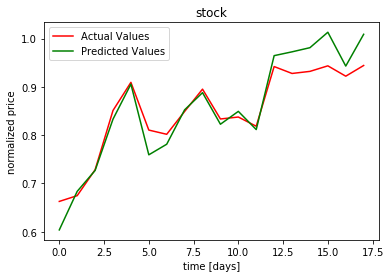

In [16]:
results = estimator.predict(test_input)
 
Yout_ = [result["Yout"] for result in results]
 
predict = np.array(Yout_)
 
actual = y_test[:, -1]
 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(actual[:, 0], label="Actual Values", color='red')
plt.plot(predict[:, 0], label="Predicted Values", color='green', )
 
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
 
plt.show()